Michelle Hu  
---
University of Washington  
AMATH 563  
Homework 3  
Due: May 27, 2020  

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import dask.array as da
import dask
import xarray as xr

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
wd="/mnt/Backups/jmhu/git_dirs/ComplexSystems_AMATH563/hw3"
data_dir=wd+"/data/"
model_dir=wd+"/models/"

cropped_dir=data_dir + "yale_cropped/"
uncropped_dir=data_dir + "yale_uncropped/"

### Functions

In [5]:
import glob
def fn_list(thisDir, fn_pattern):
    '''
    Function that returns a sorted list of filenames 
    based on a regex pattern in specified directory
    '''
    fns=[]
    for f in glob.glob(thisDir + "/" + fn_pattern): fns.append(f)
    fns.sort()
    return fns

### Load data

In [6]:
cropped_fns = fn_list(data_dir+"yale_cropped/yale*", "*")
uncropped_fns = fn_list(data_dir+"yale_uncropped", "*")

## Use cropped images to compute eigenfaces 

#### Remove "bad" imagery

In [7]:
print(len(cropped_fns))
cropped_fns = [fn for fn in cropped_fns if "bad" not in fn]
print(len(cropped_fns))

2432
2414


#### Create data matrix with delayed 

In [8]:
%%time
xr_rio = dask.delayed(xr.open_rasterio, pure=True)

# Delayed
lazy=[xr_rio(fn) for fn in cropped_fns] 

# Get template
f=lazy[0].compute()

# Create dask array for image cube
arrays=[da.from_delayed(x, 
                      shape=f.shape, 
                      dtype=f.dtype) 
      for x in lazy]

# stack = da.concatenate(arrays, axis=0)

rav_stack=[np.array(x).ravel() for x in arrays]
rav_stack = da.stack(rav_stack, axis=1)

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


CPU times: user 15.1 s, sys: 1.16 s, total: 16.2 s
Wall time: 23.5 s


#### Get labels from file names --> this will be the subject label 

In [9]:
subject_labels = [fn.split("/")[-1][:7] for fn in cropped_fns]
subject_nums = [int(label[-2:]) for label in subject_labels]

### PCA

#### Split train and test sets

In [10]:
%%time
from sklearn.model_selection import train_test_split

X=np.array(rav_stack.T)
y=np.array(subject_labels)

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1810, 32256) (604, 32256) (1810,) (604,)
CPU times: user 1.59 s, sys: 266 ms, total: 1.86 s
Wall time: 1.74 s


#### Compute PCA

modified from: https://pythonmachinelearning.pro/face-recognition-with-eigenfaces/ and https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html and https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html, https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

In [11]:
%%time

from time import time
from sklearn.decomposition import PCA

n_components = 250

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

# Reshape eigenvectors into eigenfaces
eigenfaces = pca.components_.reshape((n_components, f.shape[1], f.shape[2]))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 250 eigenfaces from 1810 faces
done in 7.126s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.771s
CPU times: user 2min, sys: 24.2 s, total: 2min 24s
Wall time: 7.93 s


#### Plot top 20 eigenfaces

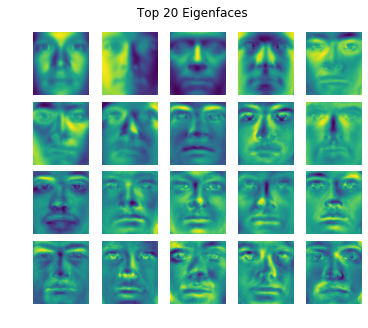

In [12]:
rows=4
cols=5

fig, axes = plt.subplots(rows, cols, figsize=(1.5*rows, cols), gridspec_kw=dict(hspace=0.1, wspace=0.1))

# Check out each of the subjects
idx=0

for row in range(rows):
    for col in range(cols):
        ax=axes[row, col]
        ax.axis("off")    

        # plot first image
        ax.imshow(eigenfaces[idx])#, cmap=plt.cm.Greys_r)
        idx+=1
plt.suptitle("Top 20 Eigenfaces", y=0.95);

### Test 1. Face Classification
Consider the various faces and see if you can build a classifier that can reasonably identify an individual face.

Using the cropped images, see if classifier can identify subjects in test sets

#### Get first image filenames of each subject

In [13]:
print("There are %i unique subjects in the dataset" 
      % len(np.unique(subject_labels)))

first_fns=fn_list(data_dir, "yale_cropped/yale*/*_P00A+000E+00.pgm*")
print(len(first_fns))

There are 38 unique subjects in the dataset
38


#### Open up the files and squeeze out singleton dimensions

In [14]:
%%time
# Delayed
first_lazy=[xr_rio(fn) for fn in first_fns] 

# Create dask array for image cube
first_imgs=[da.from_delayed(x, 
                            shape=f.shape, 
                            dtype=f.dtype)
            for x in first_lazy]

first_imgs = [np.squeeze(np.array(x)) for x in first_imgs]

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, **kwargs)


CPU times: user 216 ms, sys: 22.2 ms, total: 238 ms
Wall time: 245 ms


#### Plot each of the subject's faces

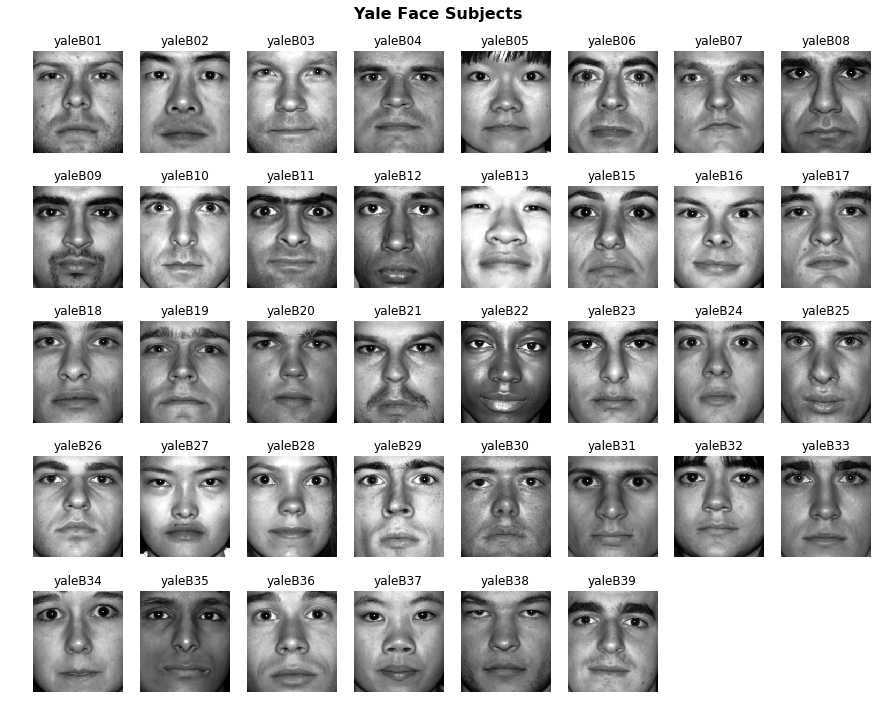

In [15]:
rows=5
cols=8

subjects = np.unique(subject_labels) # get unique subject labels
fig, axes = plt.subplots(rows, cols, figsize=(3*rows, 1.5*cols))

# Check out each of the subjects
idx=0

for row in range(rows):
    for col in range(cols):
        ax=axes[row, col]
        ax.axis("off")    
        if idx>=38:
            pass
        else:
            img=first_imgs[idx]
            f=subjects[idx]

            # plot first image
            ax.imshow(img, cmap=plt.cm.Greys_r)
            ax.set_title(f)

            idx+=1

plt.suptitle("Yale Face Subjects", fontsize=16, fontweight="bold", y=0.925);

#### See which subjects are represented in the training and test sets

In [16]:
print("Training:", len(np.unique(y_train)), "\n", (np.unique(y_train)))
print("\nTest:", len(np.unique(y_test)), "\n", np.unique(y_test))

Training: 38 
 ['yaleB01' 'yaleB02' 'yaleB03' 'yaleB04' 'yaleB05' 'yaleB06' 'yaleB07'
 'yaleB08' 'yaleB09' 'yaleB10' 'yaleB11' 'yaleB12' 'yaleB13' 'yaleB15'
 'yaleB16' 'yaleB17' 'yaleB18' 'yaleB19' 'yaleB20' 'yaleB21' 'yaleB22'
 'yaleB23' 'yaleB24' 'yaleB25' 'yaleB26' 'yaleB27' 'yaleB28' 'yaleB29'
 'yaleB30' 'yaleB31' 'yaleB32' 'yaleB33' 'yaleB34' 'yaleB35' 'yaleB36'
 'yaleB37' 'yaleB38' 'yaleB39']

Test: 38 
 ['yaleB01' 'yaleB02' 'yaleB03' 'yaleB04' 'yaleB05' 'yaleB06' 'yaleB07'
 'yaleB08' 'yaleB09' 'yaleB10' 'yaleB11' 'yaleB12' 'yaleB13' 'yaleB15'
 'yaleB16' 'yaleB17' 'yaleB18' 'yaleB19' 'yaleB20' 'yaleB21' 'yaleB22'
 'yaleB23' 'yaleB24' 'yaleB25' 'yaleB26' 'yaleB27' 'yaleB28' 'yaleB29'
 'yaleB30' 'yaleB31' 'yaleB32' 'yaleB33' 'yaleB34' 'yaleB35' 'yaleB36'
 'yaleB37' 'yaleB38' 'yaleB39']


##### *Note that subject 14 does not exist*

#### Plot the histograms

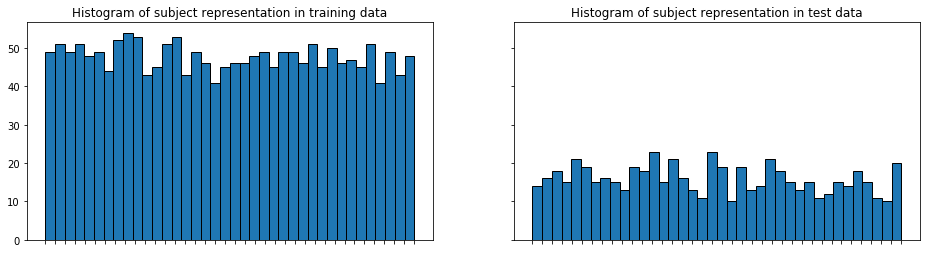

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

ax[0].hist(y_train, ec='k', bins=38);
ax[0].set_title("Histogram of subject representation in training data")

ax[0].xaxis.set_ticklabels([])
ax[1].xaxis.set_ticklabels([])

ax[1].hist(y_test, ec='k', bins=38);
ax[1].set_title("Histogram of subject representation in test data");

Looks like all subjects are represented in both train and test sets (which they should be, using train_test_split), though at varying rates

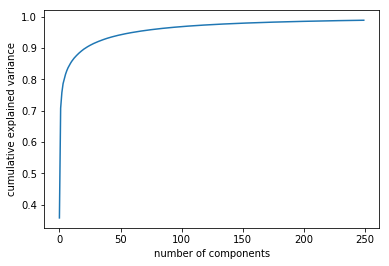

In [18]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [19]:
thresh = 0.975
cdf=np.cumsum(pca.explained_variance_ratio_)

n_comp = np.where(cdf>thresh)[0][0]
print("The first", n_comp, "explains", thresh*100, "% of variance in training set")

The first 129 explains 97.5 % of variance in training set


In [20]:
%%notify
%%time

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Instantiate model hyperparameters
param_grid = {'C': [1e0, 1e1, 1e2, 1e3, 1e4, 1e5],
              'gamma': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}

scores = ['precision', 'recall']

# Use grid search to test candidate parameters
for score in scores:
    
    clf = GridSearchCV(
        SVC(kernel='rbf', class_weight='balanced'), 
        param_grid, scoring='%s_macro' % score
    )
    
    clf.fit(X_train_pca, y_train)
    
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print()    
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_pca)
    print(classification_report(y_true, y_pred))
    print()

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib

Best parameters set found on development set:
{'C': 10.0, 'gamma': 0.0001}

Grid scores on development set:

0.058 (+/-0.016) for {'C': 1.0, 'gamma': 1e-05}
0.060 (+/-0.019) for {'C': 1.0, 'gamma': 0.0001}
0.964 (+/-0.013) for {'C': 1.0, 'gamma': 0.001}
0.938 (+/-0.018) for {'C': 1.0, 'gamma': 0.01}
0.614 (+/-0.108) for {'C': 1.0, 'gamma': 0.1}
0.026 (+/-0.012) for {'C': 10.0, 'gamma': 1e-05}
0.970 (+/-0.015) for {'C': 10.0, 'gamma': 0.0001}
0.962 (+/-0.021) for {'C': 10.0, 'gamma': 0.001}
0.943 (+/-0.019) for {'C': 10.0, 'gamma': 0.01}
0.632 (+/-0.064) for {'C': 10.0, 'gamma': 0.1}
0.969 (+/-0.015) for {'C': 100.0, 'gamma': 1e-05}
0.958 (+/-0.017) for {'C': 100.0, 'gamma': 0.0001}
0.955 (+/-0.021) for {'C': 100.0, 'gamma': 0.001}
0.940 (+/-0.014) for {'C': 100.0, 'gamma': 0.01}
0.637 (+/-0.066) for {'C': 100.0, 'gamma': 0.1}
0.956 (+/-0.014) for {'C': 1000.0, 'gamma': 1e-05}
0.951 (+/-0.019) for {'C': 1000.0, 'gamma': 0.0001}
0.950 (+/-0.022) for {'C': 1000.0, 'gamma': 0.001}
0.938 (+

<IPython.core.display.Javascript object>

In terms of both precision and recall, the best model hyperparameters are {'C': 10.0, 'gamma': 0.0001}

In [21]:
print("In terms of both precision and recall, the best model hyperparameters are:", clf.best_params_)

In terms of both precision and recall, the best model hyperparameters are: {'C': 10.0, 'gamma': 0.0001}


#### Use best model hyperparameters as model to test

In [22]:
%%time
model = clf.best_estimator_
y_pred_best = model.predict(X_test_pca)

CPU times: user 280 ms, sys: 0 ns, total: 280 ms
Wall time: 279 ms


In [23]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

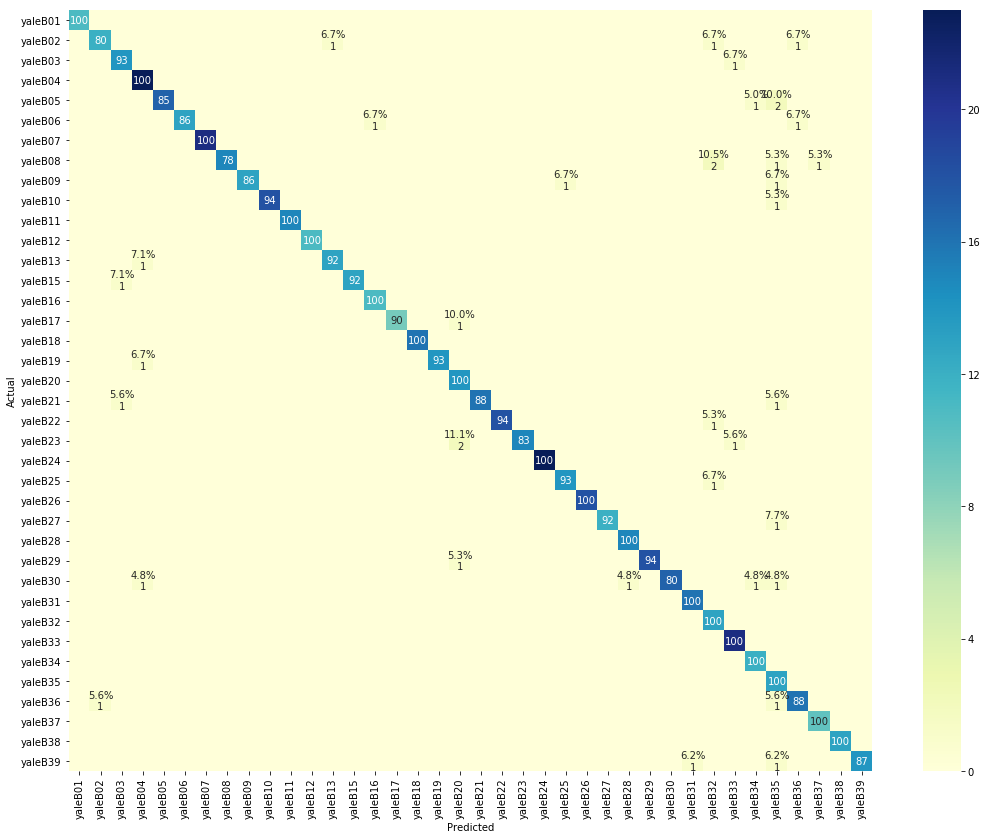

In [24]:
def plot_cm(y_true, y_pred, figsize=(18,14)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
#                 annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
                annot[i, j] = '%i' % (p)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(y_test, y_pred_best)

Misclassified indices: [ 12  43  69  82 142 158 167 179 201 217 240 257 272 279 281 324 338 347
 354 385 389 397 399 406 416 419 450 471 472 484 518 529 537 547 578 581
 585]


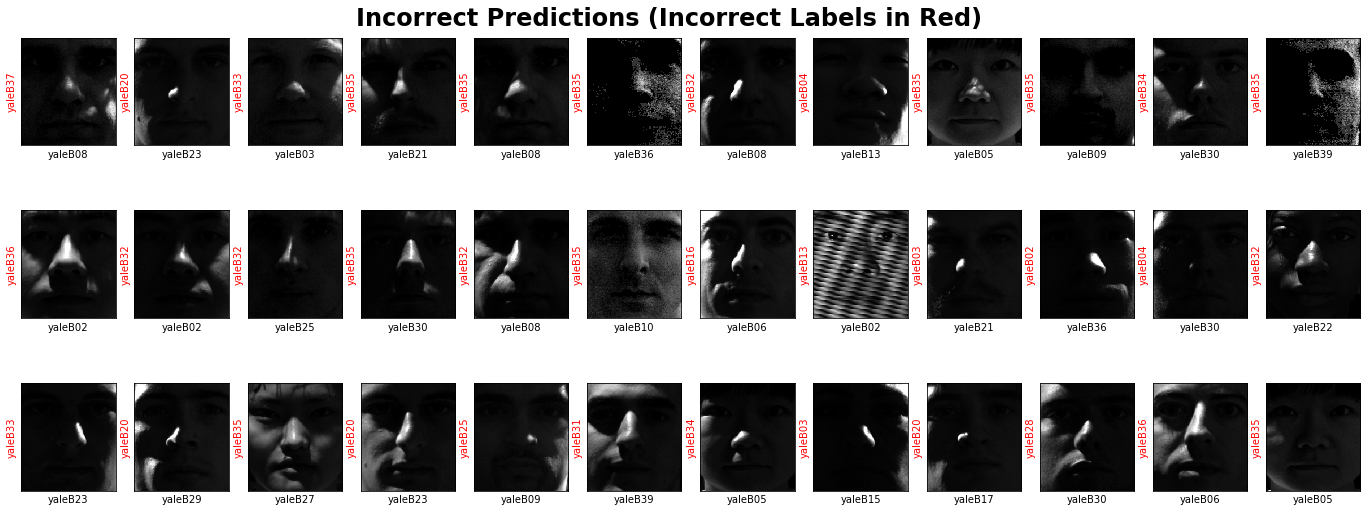

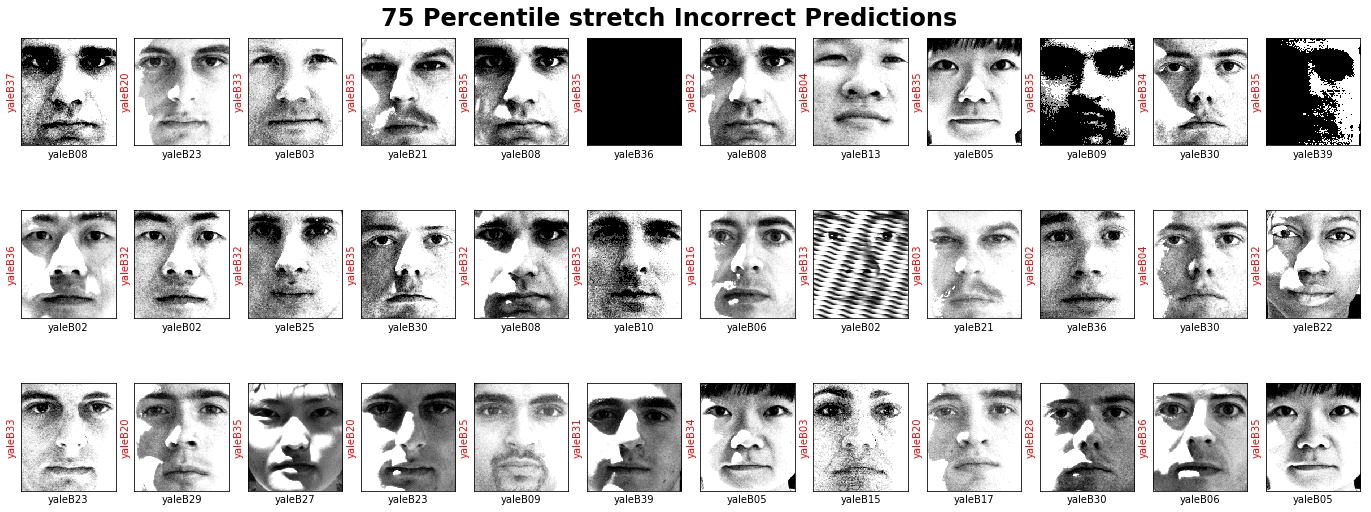

In [46]:
misclassified = np.where(y_test!=y_pred_best)[0]
print("Misclassified indices:", misclassified)


cols = round(len(misclassified)/3)
rows = round(len(misclassified)/cols)

fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 3*rows))
for (ax, img, pred_label, true_label) in zip(axes.flat, 
                                         X_test[misclassified], 
                                         y_pred_best[misclassified], 
                                         y_test[misclassified]):
    
    ax.imshow(img.reshape(192, 168), cmap='Greys_r')
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel(pred_label, color='red')
    ax.set_xlabel(true_label, color='k')
    
fig.suptitle('Incorrect Predictions (Incorrect Labels in Red)', size=24, weight="bold", y=0.9);

fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 3*rows))
for (ax, img, pred_label, true_label) in zip(axes.flat, 
                                         X_test[misclassified], 
                                         y_pred_best[misclassified], 
                                         y_test[misclassified]):
    
    ax.imshow(img.reshape(192, 168), cmap='Greys_r', vmin=0, vmax=np.percentile(img, 75))
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel(pred_label, color='red')
    ax.set_xlabel(true_label, color='k')
    
fig.suptitle('75 Percentile stretch Incorrect Predictions', size=24, weight="bold", y=0.9);

# Would be nice to plot pairs of predictions predicted vs. true

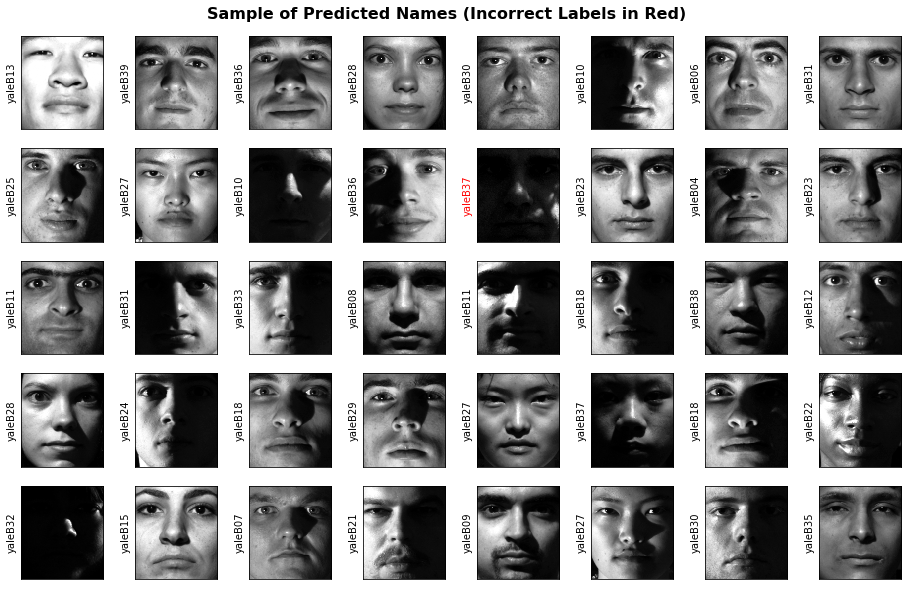

In [25]:
rows = 5
cols = 8
fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(192, 168), cmap='Greys_r')
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel(y_pred_best[i],
                   color='black' if y_pred_best[i] == y_test[i] else 'red')
fig.suptitle('Sample of Predicted Names (Incorrect Labels in Red)', size=16, weight="bold", y=0.92);

---

### Test 2. Gender classification
Can you build an algorithm capable of recognizing men from women?

Changing objective and question to identifying people with substantial facial hair used as adornment.

**Approach:** Create new labels --> for all faces in folder, do this to recognize people with facial hair
people with facial hair are subject 9 and subject 21

these are imbalanced classes, but the weight parameter choice of 'balanced' adjusts class weights according to the frequency

#### 1. Work from X and y (original images and labels)

In [26]:
X.shape, y.shape

((2414, 32256), (2414,))

#### 2. Assign new labels y based on original labels (which should be based on the subject filename)

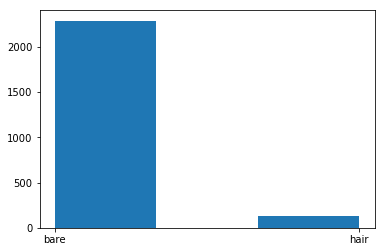

In [27]:
y_hair = np.array([ "hair" if (num == 9) or (num == 21) else "bare" for label, num in zip(y, subject_nums) ])

plt.hist(y_hair, bins=3);

#### 3. Resplit these train and test labels

In [28]:
%%time
# split into a training and testing set
X_train_hair, X_test_hair, y_train_hair, y_test_hair = train_test_split(
    X, y_hair, test_size=0.25, random_state=42)

print(X_train_hair.shape, X_test_hair.shape, y_train_hair.shape, y_test_hair.shape)

(1810, 32256) (604, 32256) (1810,) (604,)
CPU times: user 31.7 ms, sys: 15.7 ms, total: 47.4 ms
Wall time: 15.5 ms


and check the split

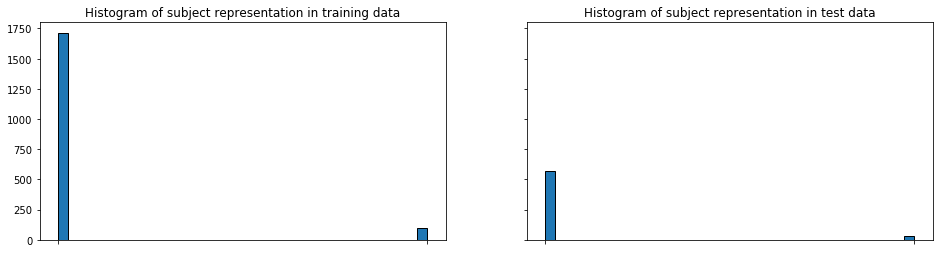

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

ax[0].hist(y_train_hair, ec='k', bins=38);
ax[0].set_title("Histogram of subject representation in training data")

ax[0].xaxis.set_ticklabels([])
ax[1].xaxis.set_ticklabels([])

ax[1].hist(y_test_hair, ec='k', bins=38);
ax[1].set_title("Histogram of subject representation in test data");

#### 4. Run PCA and transform the data

In [30]:
%%time
n_components = 250

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train_hair)

# Reshape eigenvectors into eigenfaces
eigenfaces_hair = pca.components_.reshape((n_components, img.shape[0], img.shape[1]))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_hair_pca = pca.transform(X_train_hair)
X_test_hair_pca = pca.transform(X_test_hair)

Projecting the input data on the eigenfaces orthonormal basis
CPU times: user 2min 3s, sys: 21.6 s, total: 2min 25s
Wall time: 7.79 s


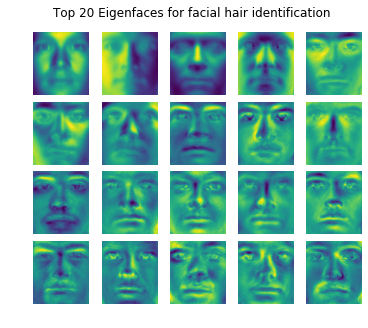

In [31]:
rows=4
cols=5

fig, axes = plt.subplots(rows, cols, figsize=(1.5*rows, cols), gridspec_kw=dict(hspace=0.1, wspace=0.1))

# Check out each of the subjects
idx=0

for row in range(rows):
    for col in range(cols):
        ax=axes[row, col]
        ax.axis("off")    

        # plot first image
        ax.imshow(eigenfaces_hair[idx])#, cmap=plt.cm.Greys_r)
        idx+=1
plt.suptitle("Top 20 Eigenfaces for facial hair identification", y=0.95);

#### 5. Use new labels to train a classifier using PCA transformed X data

In [32]:
%%notify
%%time
# Use grid search to test candidate parameters
for score in scores:
    
    clf = GridSearchCV(
        SVC(kernel='rbf', class_weight='balanced'), 
        param_grid, scoring='%s_macro' % score
    )
    
    clf.fit(X_train_hair_pca, y_train_hair)
    
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print()    
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    print()
    y_true, y_pred = y_test_hair, clf.predict(X_test_hair_pca)
    print(classification_report(y_true, y_pred))
    print()

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib

/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jmhu/miniconda/envs/gda_py3/lib

Best parameters set found on development set:
{'C': 1.0, 'gamma': 0.001}

Grid scores on development set:

0.474 (+/-0.000) for {'C': 1.0, 'gamma': 1e-05}
0.997 (+/-0.004) for {'C': 1.0, 'gamma': 0.0001}
0.998 (+/-0.004) for {'C': 1.0, 'gamma': 0.001}
0.989 (+/-0.004) for {'C': 1.0, 'gamma': 0.01}
0.474 (+/-0.000) for {'C': 1.0, 'gamma': 0.1}
0.997 (+/-0.004) for {'C': 10.0, 'gamma': 1e-05}
0.977 (+/-0.037) for {'C': 10.0, 'gamma': 0.0001}
0.981 (+/-0.046) for {'C': 10.0, 'gamma': 0.001}
0.989 (+/-0.004) for {'C': 10.0, 'gamma': 0.01}
0.474 (+/-0.000) for {'C': 10.0, 'gamma': 0.1}
0.977 (+/-0.037) for {'C': 100.0, 'gamma': 1e-05}
0.987 (+/-0.027) for {'C': 100.0, 'gamma': 0.0001}
0.997 (+/-0.003) for {'C': 100.0, 'gamma': 0.001}
0.989 (+/-0.004) for {'C': 100.0, 'gamma': 0.01}
0.474 (+/-0.000) for {'C': 100.0, 'gamma': 0.1}
0.987 (+/-0.027) for {'C': 1000.0, 'gamma': 1e-05}
0.968 (+/-0.047) for {'C': 1000.0, 'gamma': 0.0001}
0.997 (+/-0.003) for {'C': 1000.0, 'gamma': 0.001}
0.989 (+/-

<IPython.core.display.Javascript object>

In [33]:
print("In terms of both precision and recall, the best model hyperparameters are:", clf.best_params_)

In terms of both precision and recall, the best model hyperparameters are: {'C': 100.0, 'gamma': 0.0001}


In [34]:
%%time
model_hair = clf.best_estimator_
y_pred_hair_best = model_hair.predict(X_test_hair_pca)

CPU times: user 24.8 ms, sys: 0 ns, total: 24.8 ms
Wall time: 24.3 ms


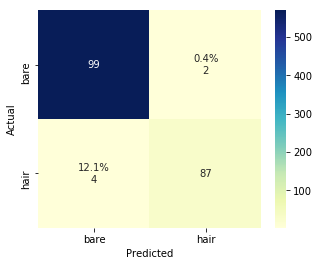

In [35]:
plot_cm(y_test_hair, y_pred_hair_best, figsize=(5,4))

#### Plot only the incorrectly labeled ones

Misclassified indices: [141 217 389 472 550 582]


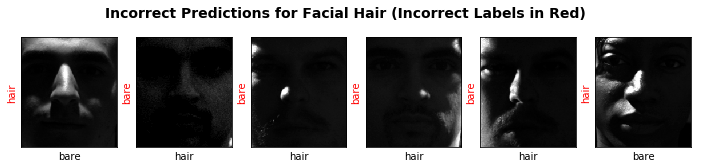

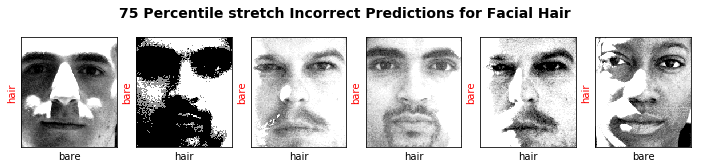

In [37]:
misclassified = np.where(y_test_hair!=y_pred_hair_best)[0]
print("Misclassified indices:", misclassified)

rows = 1
cols = len(misclassified)

fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 3*rows))
for (ax, img, pred_label, true_label) in zip(axes.flat, 
                                         X_test_hair[misclassified], 
                                         y_pred_hair_best[misclassified], 
                                         y_test_hair[misclassified]):
    
    ax.imshow(img.reshape(192, 168), cmap='Greys_r')
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel(pred_label, color='red')
    ax.set_xlabel(true_label, color='k')
    
fig.suptitle('Incorrect Predictions for Facial Hair (Incorrect Labels in Red)', size=14, weight="bold", y=0.9);

fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 3*rows))
for (ax, img, pred_label, true_label) in zip(axes.flat, 
                                         X_test_hair[misclassified], 
                                         y_pred_hair_best[misclassified], 
                                         y_test_hair[misclassified]):
    
    ax.imshow(img.reshape(192, 168), cmap='Greys_r', vmin=0, vmax=np.percentile(img, 75))
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel(pred_label, color='red')
    ax.set_xlabel(true_label, color='k')
    
fig.suptitle('75 Percentile stretch Incorrect Predictions for Facial Hair', size=14, weight="bold", y=0.9);

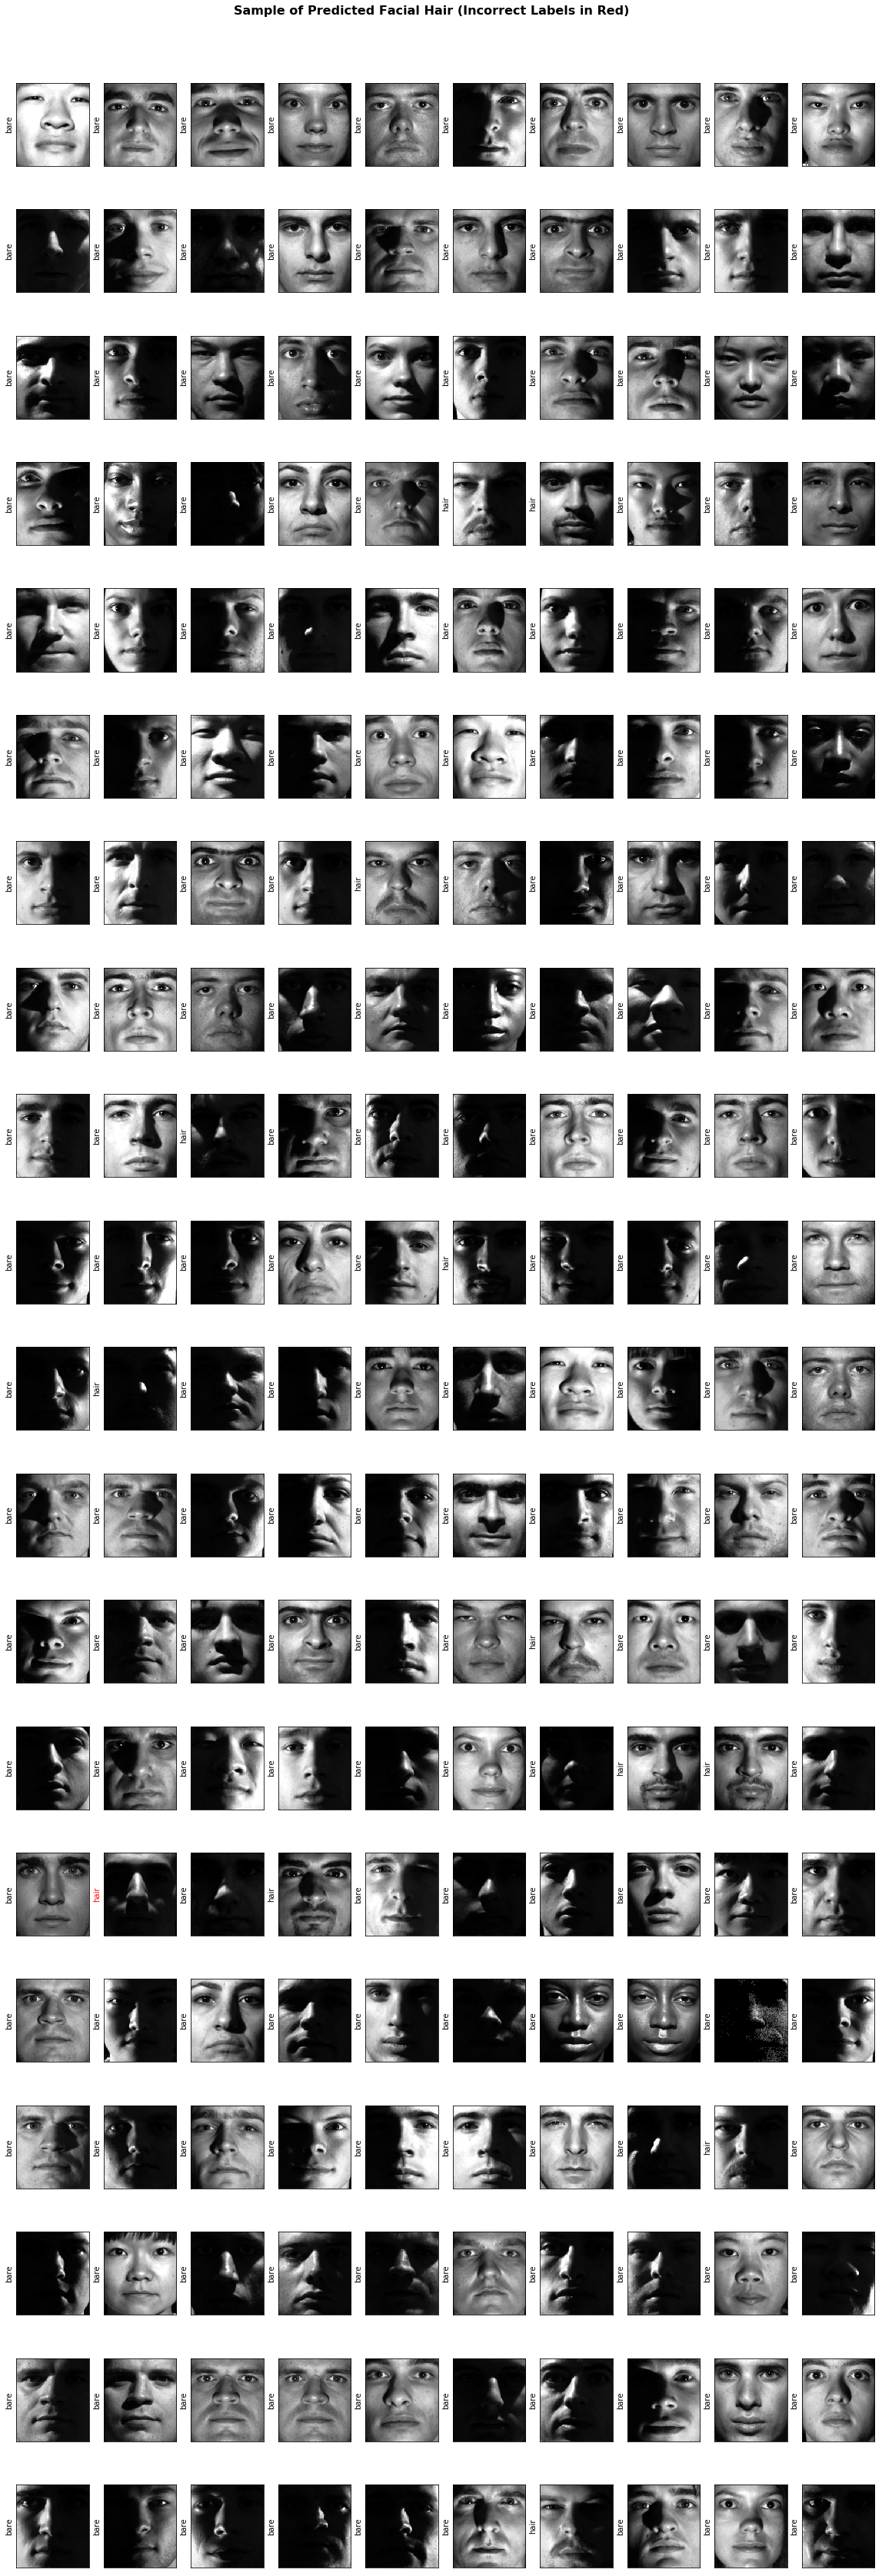

In [38]:
rows = 20
cols = 10
fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 3*rows))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_hair[i].reshape(192, 168), cmap='Greys_r')
    ax.set(xticks=[], yticks=[])
    ax.set_ylabel(y_pred_hair_best[i],
                   color='black' if y_pred_hair_best[i] == y_test_hair[i] else 'red')
fig.suptitle('Sample of Predicted Facial Hair (Incorrect Labels in Red)', size=16, weight="bold", y=0.9);

---

### Test 3. Unsupervised algorithms
In an unsupervised way, can you develop algorithms that automatically find patterns in the faces that naturally cluster?

Start with 4-6 clusters for speed

In [ ]:
%%time
from sklearn.cluster import KMeans

clusters=4
n_jobs=8

kmeans = KMeans(n_clusters=clusters, n_jobs=n_jobs)
kmeans

#### Train the model on the PCA-transformed data

In [ ]:
%%time
kmeans.fit(X_train_pca)

#### Check out cluster centroids

In [ ]:
kmeans.cluster_centers_

#### Plot over top eigenface

#### Predict labels and check accuracy

In [ ]:
y_preds_kmeans = kmeans.predict(X_test_pca)

In [ ]:
import dask_ml.cluster